# Random Forest

In [2]:
%reload_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(".."))

from src.data_eng.pipeline import run_pipeline

In [3]:
from src.config import Config

conf = Config(
    #features=[], all features
    add_int_features=True,
    target={'horizon': 5, 'threshold': 0.01},
   # ticker_list=['AAPL','META'], #all tickers
    validate_cutoff='2022-01-01',      # FINAL TEST START
    fold_len='365D',
    fold_mode='expanding',             # or 'sliding'
    sliding_train_years=None,          # set e.g. 5 if using sliding
    #embargo_days=None                  # defaults to horizon=5
)

In [4]:
# skipping for now since we already have data, uncomment if you havent pulled data yet
# run_pipeline(conf)

In [4]:
import pandas as pd

X = pd.read_csv(conf.processed_data_path / f'{conf.ticker_list[0]}.csv')

In [5]:
from src.modeling.eval import make_global_rf_pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
from src.modeling.helpers import num_cols_fn

param_distributions = {
    "clf__n_estimators": randint(300, 900),           # more trees = smoother, slower
    "clf__max_depth": randint(3, 20),                 # smaller = more bias, larger = more variance
    "clf__min_samples_leaf": randint(1, 50),          # 5–20 often stabilizes noisy labels
    "clf__min_samples_split": randint(2, 50),
    "clf__max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],
    "clf__bootstrap": [True, False],
    "clf__max_samples": [None, 0.5, 0.7, 0.9],        # only used if bootstrap=True
    "clf__criterion": ["gini", "entropy"]
}
# inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# search = RandomizedSearchCV(
#     estimator=make_global_rf_pipeline(num_cols_fn(X)),
#     param_distributions=param_distributions,
#     n_iter=40,                
#     scoring="roc_auc",        
#     n_jobs=-1,
#     cv=inner_cv,
#     verbose=1,
#     random_state=42
# )





In [ ]:
from src.modeling.global_pairs import build_global_fold_pairs
from src.data_eng.folds import load_multi_ticker_collection
from src.modeling.eval import make_global_rf_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# 1) get data
collection = load_multi_ticker_collection(conf)

# 2) build global fold pairs (drop NaNs inside)
pairs = build_global_fold_pairs(collection, dropna_features=True)


cv_scores = []

for k, (Xtr, ytr, Xva, yva) in enumerate(pairs):
    # get numeric cols (excluding helper columns)
    num_cols = [c for c in Xtr.columns if c not in ("__ticker__", "Date")]

    # inner search on training fold
    search = RandomizedSearchCV(
        estimator=make_global_rf_pipeline(num_cols),
        param_distributions=param_distributions,
        n_iter=40,
        scoring="roc_auc",
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        verbose=0,
        random_state=42
)
    search.fit(Xtr, ytr)

    # evaluate best on this outer validation fold
    best_pipe = search.best_estimator_
    y_proba = best_pipe.predict_proba(Xva)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    cv_scores.append({
        "fold": k,
        "roc_auc": roc_auc_score(yva, y_proba),
        "accuracy": accuracy_score(yva, y_pred),
        "n_val": len(Xva),
        "best_params": search.best_params_
    })

/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
48 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mike/Git

In [23]:
import numpy as np
arr = np.zeros(len(cv_scores), dtype=float)

for i, result in enumerate(cv_scores):
   # print(result)
   # print(result['roc_auc'])
    arr[i] = float(result['roc_auc'])

# fold with best roc_auc
best_fold_id = pd.Series(arr).idxmax()

best_fold = cv_scores[best_fold_id]

print(f'Best in fold ROC_AUC: {best_fold['roc_auc']}, acc: {best_fold['accuracy']}')

best_fold['best_params']




Best in fold ROC_AUC: 0.563393424963335, acc: 0.5566648677819752


{'clf__bootstrap': True,
 'clf__criterion': 'gini',
 'clf__max_depth': 15,
 'clf__max_features': 'sqrt',
 'clf__max_samples': None,
 'clf__min_samples_leaf': 15,
 'clf__min_samples_split': 46,
 'clf__n_estimators': 364}

Best Params:
```raw
{'clf__bootstrap': True,
 'clf__criterion': 'gini',
 'clf__max_depth': 15,
 'clf__max_features': 'sqrt',
 'clf__max_samples': None,
 'clf__min_samples_leaf': 15,
 'clf__min_samples_split': 46,
 'clf__n_estimators': 364}
 ```

## Final Test

In [27]:
from src.modeling.global_pairs import build_global_insample_and_test


X_ins, y_ins, X_test, y_test = build_global_insample_and_test(collection, dropna_features=True)
num_cols = [c for c in X_ins.columns if c not in ("__ticker__", "Date")]

preprocessor, _, final_pipe = make_global_rf_pipeline(num_cols)
final_pipe.fit(X_ins, y_ins)

final_auc = roc_auc_score(y_test, final_pipe.predict(X_test))
final_acc = accuracy_score(y_test, (final_pipe.predict(X_test)).astype(int))
print({"final_auc": final_auc, "final_acc": final_acc})

{'final_auc': 0.5187937195037493, 'final_acc': 0.6163467759327151}


# Visualize

We plot the following metrics
1. Precision-Recall curve \
expected high due to overall more up days
2. Threshold sweep \
metrics vs a threshold score \
can help pick decision threshold based on metric
3. Calibration Curve + Brier Score \
Measure of predicted probability calibration
4. Confusion Matrix at given threshold
5. Confusion Matrix at best Youden J
6. Cumulative gains \
Capture positive rate
7. Per ticker average precision \
Checks how the model performs for specific tickers
8. Rolling accuracy over time \
basically shows the model is random


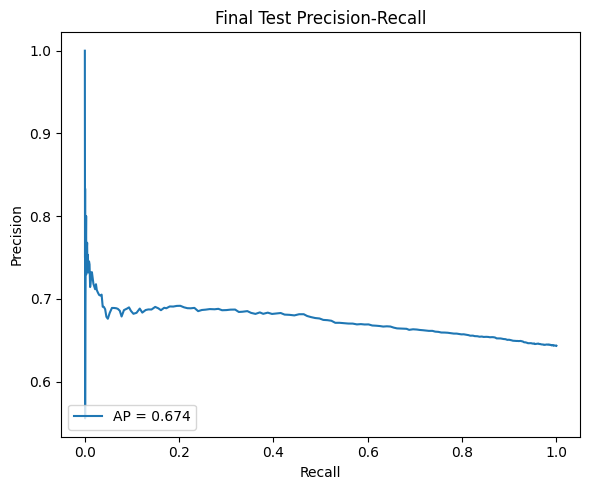

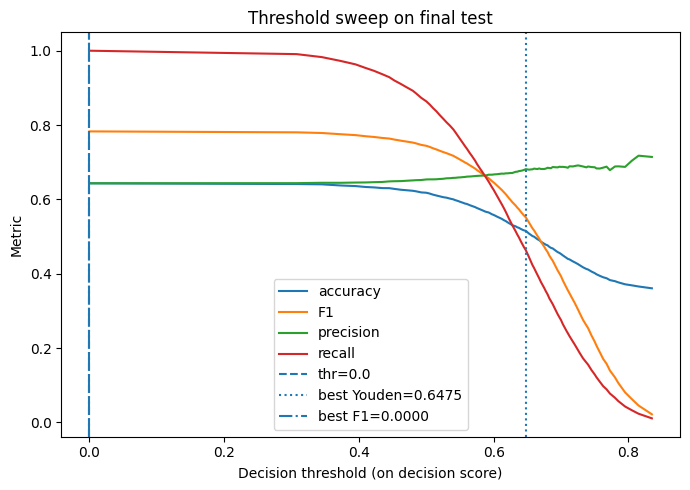

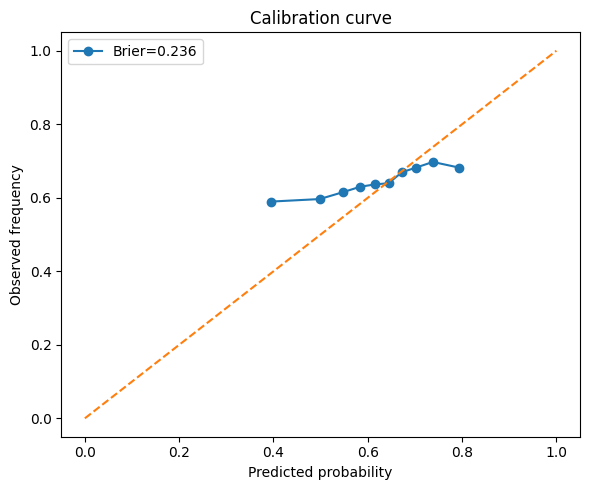

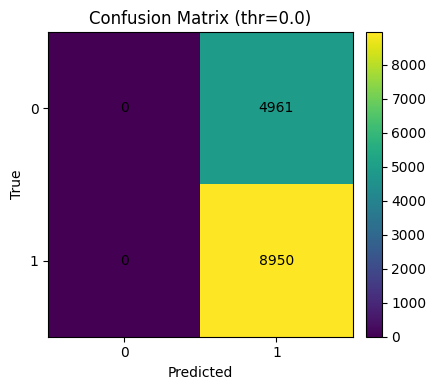

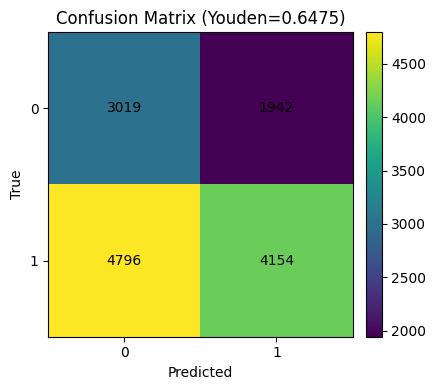

Report @ thr=0.0
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      4961
           1      0.643     1.000     0.783      8950

    accuracy                          0.643     13911
   macro avg      0.322     0.500     0.391     13911
weighted avg      0.414     0.643     0.504     13911


Report @ best Youden
              precision    recall  f1-score   support

           0      0.386     0.609     0.473      4961
           1      0.681     0.464     0.552      8950

    accuracy                          0.516     13911
   macro avg      0.534     0.536     0.512     13911
weighted avg      0.576     0.516     0.524     13911



/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

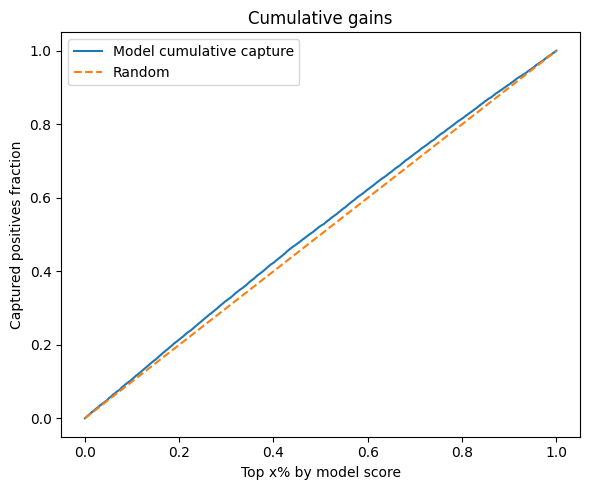

/home/mike/Git-projects/StockPrediction/src/visualization/eval_plots.py:243: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_ticker = df_eval.groupby("ticker").apply(


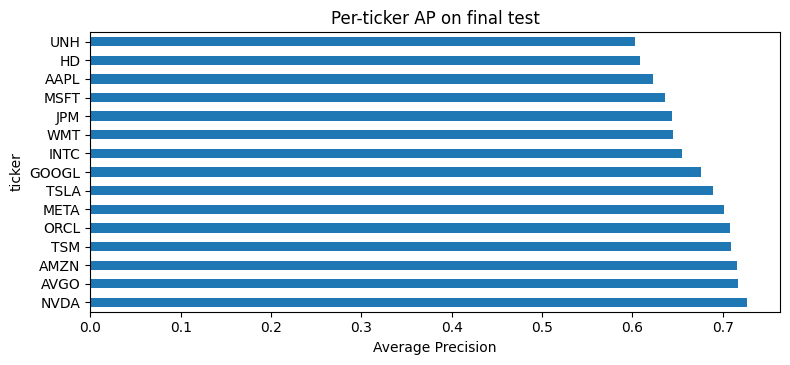

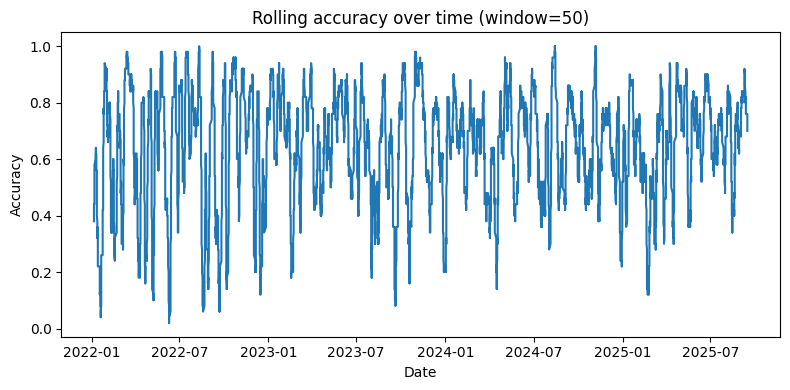

In [24]:
from src.visualization.eval_plots import run_full_eval_and_plots

df_eval, stats, sweep = run_full_eval_and_plots(
    final_pipe,
    X_test,
    y_test,
    out_dir=conf.data_dir / "model_metrics" / 'rf',
    proba_strategy="auto",   # "model" for real probs, "sigmoid" to force margin->prob, "none" to skip probs
)

# Feature Importance

Transformed feature count: 35
First few transformed names: ['Return_1d', 'SMA_5', 'SMA_20', 'SMA_ratio', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower', 'BB_width']


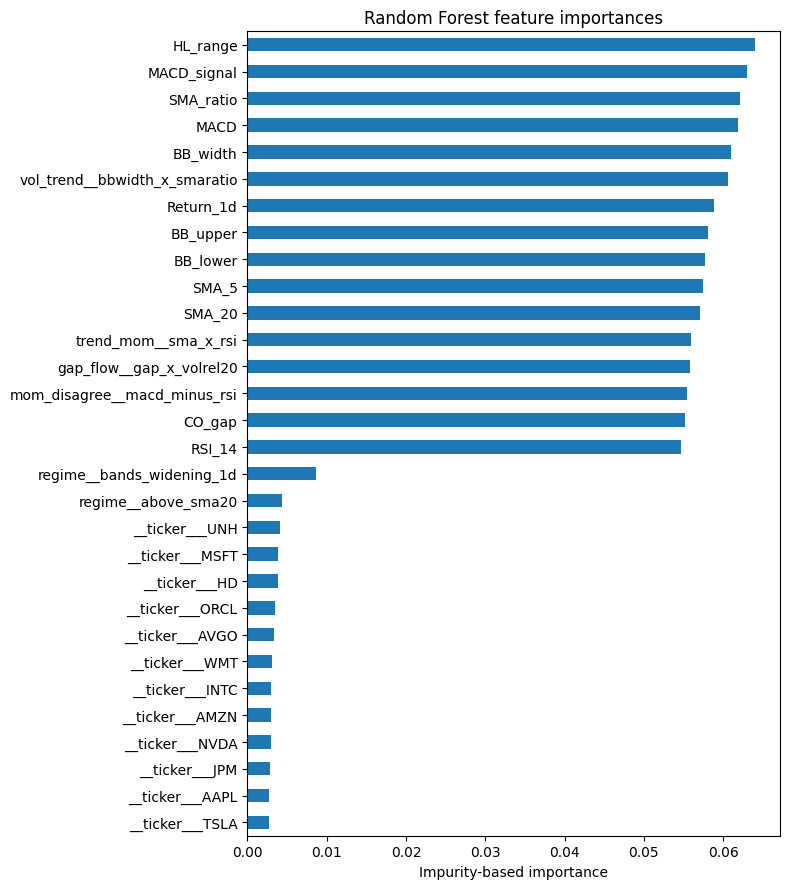

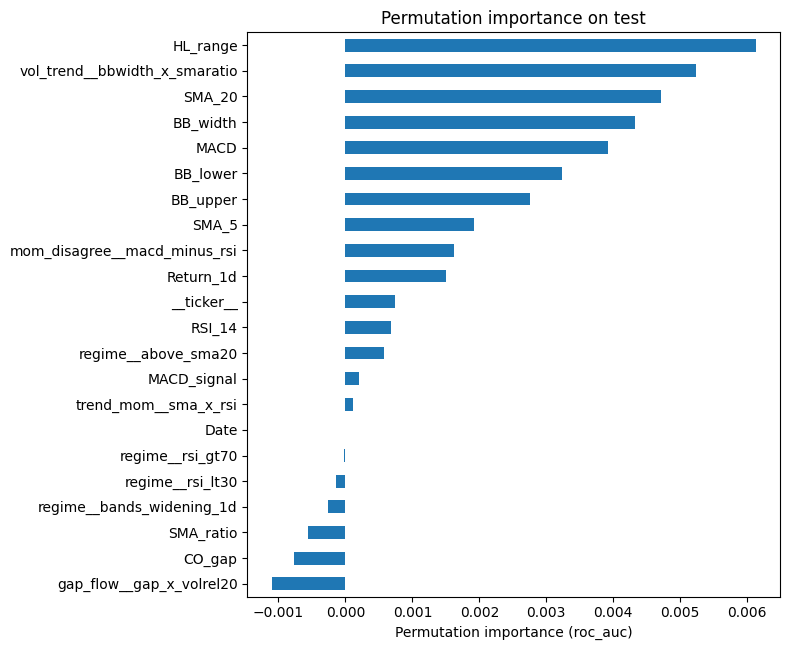

/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 16 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 17 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/home/mike/Git-projects/St

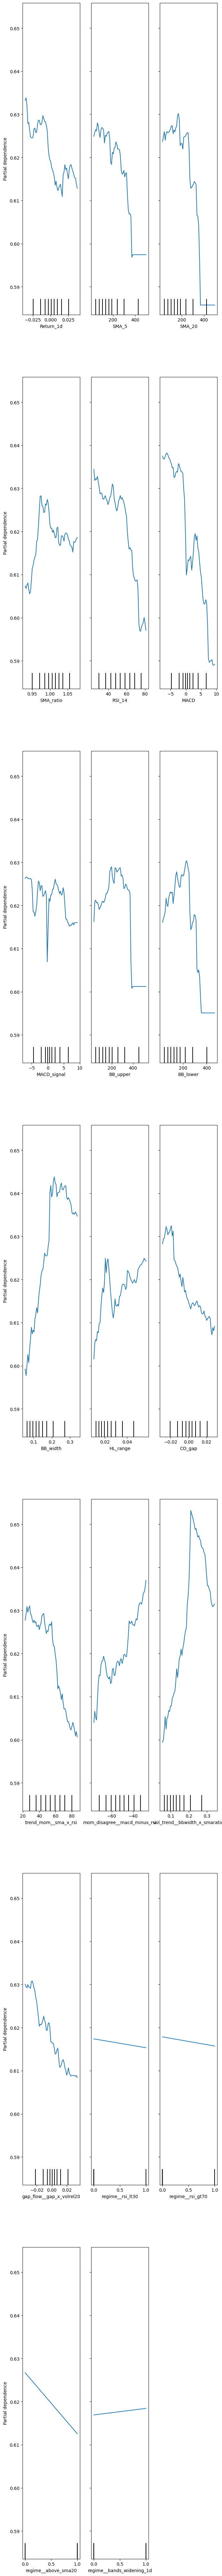

In [36]:
from src.visualization.feature_plots import (
    plot_rf_impurity_importance,
    plot_permutation_importance_on_test,
    plot_partial_dependence_top,
    get_transformed_feature_names,
)


pre, rf, final_pipe = make_global_rf_pipeline(num_cols)

# fit the pipeline
final_pipe.fit(X_ins, y_ins)

# important: only __ticker__ is categorical in your pipeline
cat_cols = ['__ticker__']

# get transformed feature names in the order seen by RF
preprocessor = final_pipe.named_steps["pre"]
tf_names = get_transformed_feature_names(
    preprocessor=preprocessor,
    numeric_cols=num_cols,
    cat_cols=cat_cols,
)

print("Transformed feature count:", len(tf_names))
print("First few transformed names:", tf_names[:10])

# 1) Impurity-based feature importance (fast)
importances = plot_rf_impurity_importance(
    final_pipe,
    feature_names=tf_names,
    top=30
)

# 2) Permutation importance on the final test set (honest, slower)
perm_imp, perm_raw = plot_permutation_importance_on_test(
    final_pipe,
    X_test,
    y_test,
    scoring="roc_auc",   
    n_repeats=10,
    random_state=42,
    top=30
)

# 3) Partial dependence for a few key numeric features
# pick your top few numeric drivers from `importances` or domain sense:
pdp_feats = num_cols # all for now? not sure what is best
# filter to ones that actually exist in X_test
pdp_feats = [f for f in pdp_feats if f in X_test.columns]

if pdp_feats:
    plot_partial_dependence_top(
        final_pipe,
        X_test,
        features=pdp_feats,
        kind="average",
        grid_resolution=60
    )
else:
    print("No PDP features found among X_test columns; update pdp_feats.")
